In [1]:
!pip install evaluate
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16165 sha256=1c25bb32eb87271329153edf444966ca128232f3cb3c5fe47efbc03f04aba6ae
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
import os
import string
from typing import List
import warnings
import numpy as np
import pandas as pd
from itertools import chain
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import nltk
import spacy
import re
from tqdm import tqdm

from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier

import torch
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Check for CUDA availability for GPU training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device {device}')

In [2]:
from torch.nn import Transformer

Transformer()

Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, o

<a id='Token_classification_with_Transformers'></a>
# Token classification with Transformers

In [4]:
import pandas as pd

df_locations_ua = pd.read_csv('/kaggle/input/mantis-analytics-location-detection/uk_geo_dataset.csv')
df_locations_ru = pd.read_csv('/kaggle/input/mantis-analytics-location-detection/ru_geo_dataset.csv')

df_locations_ru = df_locations_ru.sample(frac=0.02)
df_locations_ua = df_locations_ua.sample(frac=0.1)

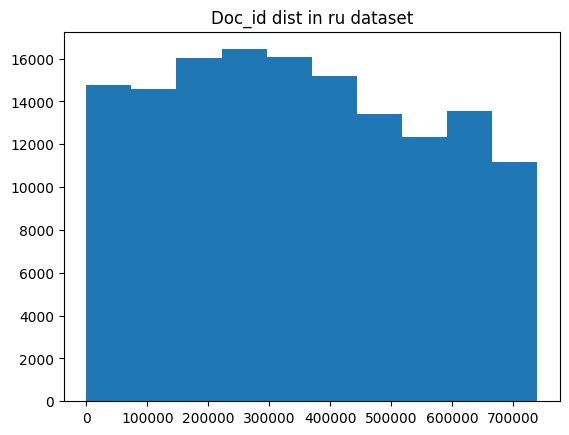

In [5]:
plt.title("Doc_id dist in ru dataset")
plt.hist(dict(df_locations_ru['doc_id'].value_counts()))
plt.show()

In [6]:
df_locations_ru['is_valid'] = 0  # Initialize 'is_valid' to 0 for all rows
df_locations_ru.loc[df_locations_ru['doc_id'] >= 700000, 'is_valid'] = 1

In [7]:
len(df_locations_ru[df_locations_ru['is_valid'] == 0]), len(df_locations_ru[df_locations_ru['is_valid'] == 1])

(154606, 5971)

In [8]:
df_locations_ru.drop(['doc_id', 'sent_id'], axis=1,inplace=True)

In [9]:
df_locations_ru

,text,loc_markers,org_markers,per_markers,is_valid
746223,"При этом власти предупредили, что результаты г...",[],[],[],0
7079421,В 2000 году 85 процентов советского долга Росс...,"[(42, 48), (94, 101)]",[],[],0
435472,7 февраля он прибыл в cледственное подразделен...,"[(60, 66), (77, 93)]","[(49, 55), (56, 59)]",[],0
2860925,"Президент Европарламента Мартин Шульц, в свою ...","[(192, 198)]","[(10, 24)]","[(25, 37)]",0
6811590,В среду они прекратили обмен трафиком друг с д...,[],[],[],0
...,...,...,...,...,...
2277905,Они сняли на видео возмутивший их момент.,[],[],[],0
4934745,Текст интервью опубликован на сайте ФСВТС.,[],"[(36, 41)]",[],0
7613749,Он допускает сохранение анонимности свидетелей...,[],[],[],0
7566477,"Двое из боевиков, захваченных в ходе боевых де...","[(67, 74), (77, 86), (103, 109)]",[],[],0


In [10]:
df_locations = pd.concat([df_locations_ru, df_locations_ua])

df_locations_copy = df_locations.copy()

df_locations.sample(10)

,text,loc_markers,org_markers,per_markers,is_valid
752048,Публикация набрала более 100 тысяч лайков в сети.,[],[],[],0
6220218,"В ""Базовом элементе"" считают, что это потребуе...",[],"[(3, 19)]",[],0
545665,"Такого результату вдалося досягти, — зазначив ...","[(83, 105)]","[(77, 80)]","[(106, 119)]",0
254108,На засіданні виконавчого комітету за таке ріше...,[],[],[],0
985803,"Рік тому його розглянули у першому читанні, ал...",[],[],"[(97, 111)]",0
913548,"Теплий, затишний одяг може бути досить красиви...",[],[],[],0
4562183,"На ""русских торгах"", проведенных аукционным до...","[(63, 70)]","[(50, 60)]",[],0
6636883,"Как сообщает Корреспондент.net, ""за"" этот зако...",[],[],[],0
4912979,Постановка в Тарлетонском университете - проек...,[],"[(13, 38)]","[(68, 95)]",0
8328,Сьогодні Близнюкам варто привести всі свої док...,[],[],"[(9, 18)]",0


In [11]:
df_locations.shape

(261577, 5)

## Text file in CoNLL format
The CoNLL format is a text file with one word per line with sentences separated by an empty line. The first word in a line should be the word and the last word should be the label.

Consider the two sentences below;

Harry Potter was a student at Hogwarts<br>
Albus Dumbledore founded the Order of the Phoenix<br>
**These two sentences can be prepared in a CoNLL formatted text file as follows:**

> Harry B-PER <br>
> Potter I-PER<br>
> was O<br>
> a O<br>
> student B-MISC<br>
> at B-PER
> Hogwarts I-PER<br>

> Albus B-PER<br>
> Dumbledore I-PER<br>
> founded O<br>
> the O<br>
> Order B-ORG<br>
> of I-ORG<br>
> the I-ORG<br>
> Phoenix I-ORG<br>

In [12]:
df_locations = df_locations_copy.copy()

df_locations

,text,loc_markers,org_markers,per_markers,is_valid
746223,"При этом власти предупредили, что результаты г...",[],[],[],0
7079421,В 2000 году 85 процентов советского долга Росс...,"[(42, 48), (94, 101)]",[],[],0
435472,7 февраля он прибыл в cледственное подразделен...,"[(60, 66), (77, 93)]","[(49, 55), (56, 59)]",[],0
2860925,"Президент Европарламента Мартин Шульц, в свою ...","[(192, 198)]","[(10, 24)]","[(25, 37)]",0
6811590,В среду они прекратили обмен трафиком друг с д...,[],[],[],0
...,...,...,...,...,...
187912,Україна і Білорусь спільно досліджуватимуть Ан...,"[(0, 7), (10, 18), (44, 54)]",[],[],0
299145,"“Розкішна жінка”, “Тіно, неймовірна красива”, ...",[],[],[],0
850589,Суперник української збірної по фіналу стала з...,"[(52, 67)]",[],[],0
58815,"За останній рік, відзначали виступаючі, ситуац...","[(107, 114)]",[],[],0


In [13]:
import spacy

from spacy.training.iob_utils import biluo_to_iob, doc_to_biluo_tags
from tqdm.autonotebook import tqdm
tqdm.pandas()

df_locations.loc_markers = df_locations.loc_markers.apply(lambda x: [[y[0], y[1], 'LOC']  for y in eval(x)])

nlp = spacy.blank("xx")

def convert_to_conll(row):
    data = {
        "text": row['text'],
        "label": row['loc_markers']
    }
    doc = nlp.make_doc(data["text"])  # Create a Doc without linguistic analysis
    ents = []
    for start, end, label in data["label"]:
        # Check if the start and end positions are valid
        if start >= 0 and end <= len(data["text"]):
            span = doc.char_span(start, end, label=label)
            if span is not None:
                ents.append(span)
    doc.ents = ents
    
    tokens = [t.text for t in doc]
    
    # Create IOB2 tags for the entities
    iob_tags = ['O'] * len(tokens)
    for ent in ents:
        for token in doc:
            if token.idx == ent.start:
                iob_tags[token.i] = 'B-' + ent.label_
            elif ent.start < token.idx < ent.end:
                iob_tags[token.i] = 'I-' + ent.label_

    return {
        'tokens': tokens,
        'labels': iob_tags
    }


df_locations['conll'] = df_locations.progress_apply(convert_to_conll, axis=1)

  0%|          | 0/261577 [00:00<?, ?it/s]

In [14]:
label2id = {'O': 0, 'B-LOC': 1, 'I-LOC': 2}

df_locations['tokens'] = df_locations.conll.str['tokens']
df_locations['ner_tags'] = df_locations.conll.str['labels'].apply(lambda x: [label2id[t] for t in x])

df_train = df_locations[df_locations.is_valid == 0]
df_valid = df_locations[df_locations.is_valid == 1]

In [15]:
df_train[['tokens', 'ner_tags']].to_json(
    'train_processed.json', orient='records', lines=True)
df_valid[['tokens', 'ner_tags']].to_json(
    'valid_processed.json', orient='records', lines=True)

In [16]:
from datasets import load_dataset

raw_datasets_ua = load_dataset(
    "json",
    data_files={
        'train': 'train_processed.json',
        'val': 'valid_processed.json'
    }
)
raw_datasets_ua

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-120186137cf42ed2/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 254564
    })
    val: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 7013
    })
})

In [17]:
from transformers import AutoTokenizer, AutoModelForTokenClassification


id2label = {v: k for k, v in label2id.items()}

model = AutoModelForTokenClassification.from_pretrained(
    'bert-base-multilingual-cased',
    id2label=id2label,
    label2id=label2id,
)
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


If we try youscan/ukr-roberta-base as pretrained model we will get worse results even if train it a bit more than the  multilingual model.

In [18]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)


def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for i in range(len(word_ids)):
        word_id = word_ids[i]
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as the previous token
            label = labels[word_id]
            # If the label is B-XXX, change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels


def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [19]:
raw_datasets_ua

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 254564
    })
    val: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 7013
    })
})

In [20]:
tokenized_datasets_ua = raw_datasets_ua.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets_ua["train"].column_names,
)

  0%|          | 0/255 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

In [21]:
from transformers import TrainingArguments

args = TrainingArguments(
    "bert-ua-loc-ner",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3
)

In [22]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW([
    {'params': list(model.bert.parameters()), 'lr': 1e-5},
    {'params': list(model.classifier.parameters()), 'lr': 1e-3}
])

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0.1*3*(tokenized_datasets_ua['train'].num_rows/16),
    num_training_steps=3*(tokenized_datasets_ua['train'].num_rows/16)
)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
import evaluate
import numpy as np

metric = evaluate.load("seqeval")

label_names = list(label2id.keys())

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [24]:
df_locations

,text,loc_markers,org_markers,per_markers,is_valid,conll,tokens,ner_tags
746223,"При этом власти предупредили, что результаты г...",[],[],[],0,"{'tokens': ['При', 'этом', 'власти', 'предупре...","[При, этом, власти, предупредили, ,, что, резу...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7079421,В 2000 году 85 процентов советского долга Росс...,"[[42, 48, LOC], [94, 101, LOC]]",[],[],0,"{'tokens': ['В', '2000', 'году', '85', 'процен...","[В, 2000, году, 85, процентов, советского, дол...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
435472,7 февраля он прибыл в cледственное подразделен...,"[[60, 66, LOC], [77, 93, LOC]]","[(49, 55), (56, 59)]",[],0,"{'tokens': ['7', 'февраля', 'он', 'прибыл', 'в...","[7, февраля, он, прибыл, в, cледственное, подр...","[0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2860925,"Президент Европарламента Мартин Шульц, в свою ...","[[192, 198, LOC]]","[(10, 24)]","[(25, 37)]",0,"{'tokens': ['Президент', 'Европарламента', 'Ма...","[Президент, Европарламента, Мартин, Шульц, ,, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6811590,В среду они прекратили обмен трафиком друг с д...,[],[],[],0,"{'tokens': ['В', 'среду', 'они', 'прекратили',...","[В, среду, они, прекратили, обмен, трафиком, д...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...
187912,Україна і Білорусь спільно досліджуватимуть Ан...,"[[0, 7, LOC], [10, 18, LOC], [44, 54, LOC]]",[],[],0,"{'tokens': ['Україна', 'і', 'Білорусь', 'спіль...","[Україна, і, Білорусь, спільно, досліджуватиму...","[1, 0, 0, 0, 0, 0, 0]"
299145,"“Розкішна жінка”, “Тіно, неймовірна красива”, ...",[],[],[],0,"{'tokens': ['“', 'Розкішна', 'жінка', '”', ','...","[“, Розкішна, жінка, ”, ,, “, Тіно, ,, неймові...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
850589,Суперник української збірної по фіналу стала з...,"[[52, 67, LOC]]",[],[],0,"{'tokens': ['Суперник', 'української', 'збірно...","[Суперник, української, збірної, по, фіналу, с...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
58815,"За останній рік, відзначали виступаючі, ситуац...","[[107, 114, LOC]]",[],[],0,"{'tokens': ['За', 'останній', 'рік', ',', 'від...","[За, останній, рік, ,, відзначали, виступаючі,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [25]:

def count_locations(row):
    data = {
        "text": row['text'],
        "label": row['loc_markers']
    }
    doc = nlp.make_doc(data["text"])  # Create a Doc without linguistic analysis
    ents = []
    for start, end, label in data["label"]:
        # Check if the start and end positions are valid
        if start >= 0 and end <= len(data["text"]):
            span = doc.char_span(start, end, label=label)
            if span is not None:
                ents.append(span)
    doc.ents = ents
    
    # Count the number of location entities
    num_locations = len([ent for ent in ents if ent.label_ == 'LOC'])

    return num_locations

# Create a new column 'num_locations' with the count of locations
df_locations['num_locations'] = df_locations.progress_apply(count_locations, axis=1)

  0%|          | 0/261577 [00:00<?, ?it/s]

In [26]:
df_locations["stratify_col"] = df_locations["num_locations"]
df_locations.loc[df_locations["num_locations"] >= 14, "stratify_col"] = -1

In [27]:
df_locations.head()

,text,loc_markers,org_markers,per_markers,is_valid,conll,tokens,ner_tags,num_locations,stratify_col
746223,"При этом власти предупредили, что результаты г...",[],[],[],0,"{'tokens': ['При', 'этом', 'власти', 'предупре...","[При, этом, власти, предупредили, ,, что, резу...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0
7079421,В 2000 году 85 процентов советского долга Росс...,"[[42, 48, LOC], [94, 101, LOC]]",[],[],0,"{'tokens': ['В', '2000', 'году', '85', 'процен...","[В, 2000, году, 85, процентов, советского, дол...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,2
435472,7 февраля он прибыл в cледственное подразделен...,"[[60, 66, LOC], [77, 93, LOC]]","[(49, 55), (56, 59)]",[],0,"{'tokens': ['7', 'февраля', 'он', 'прибыл', 'в...","[7, февраля, он, прибыл, в, cледственное, подр...","[0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,2
2860925,"Президент Европарламента Мартин Шульц, в свою ...","[[192, 198, LOC]]","[(10, 24)]","[(25, 37)]",0,"{'tokens': ['Президент', 'Европарламента', 'Ма...","[Президент, Европарламента, Мартин, Шульц, ,, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1
6811590,В среду они прекратили обмен трафиком друг с д...,[],[],[],0,"{'tokens': ['В', 'среду', 'они', 'прекратили',...","[В, среду, они, прекратили, обмен, трафиком, д...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,0


In [28]:
n_splits = 4  # Number of cross-validation folds
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [29]:
from transformers import Trainer

for fold, (train_idx, valid_idx) in enumerate(stratified_kfold.split(df_locations, df_locations['stratify_col'])):
    # Split the dataset into training and validation sets for the current fold
    train_data = df_locations.iloc[train_idx]
    valid_data = df_locations.iloc[valid_idx]

    # Tokenize and preprocess the data for this fold (similar to what you did for a single split)
    tokenized_train_data = train_data.progress_apply(tokenize_and_align_labels, axis=1)
    tokenized_valid_data = valid_data.progress_apply(tokenize_and_align_labels, axis=1)

    # Create and train the model for this fold
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_train_data,
        eval_dataset=tokenized_valid_data,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        optimizers=(optimizer, scheduler)
    )
    trainer.train()

  0%|          | 0/196182 [00:00<?, ?it/s]

TypeError: 'int' object is not subscriptable

In [ ]:
trainer.save_model("bert-ua-loc-ner")

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "bert-ua-loc-ner"
token_classifier = pipeline(
    "token-classification", model=model_checkpoint, aggregation_strategy="simple"
)

In [ ]:
token_classifier(df_valid.loc[1000344].text)

In [ ]:
df_valid

In [ ]:
token_classifier(df_valid.loc[7767775].text)

In [ ]:
predictions = []
test_data = pd.read_csv("/kaggle/input/proccessed-geo-location-datasets/test.csv")

for text_id, text in zip(test_data['text_id'], test_data['text']):
    prediction = token_classifier(text)
    location_entities = [entity['word'] for entity in prediction if entity['entity_group'] == 'LOC']
    predictions.append({'text_id': text_id, 'locations': location_entities})

result_df = pd.DataFrame(predictions)
result_df.to_csv("location_predictions.csv", index=False)


In [ ]:
result_df

In [ ]:
# prediction_df = pd.DataFrame(predictions, columns=["predictions"])
# 